<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Difficult_to_train_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Networks that are difficult to train
This notebook explores some cases where the network struggles to find a near optimum solution. In some cases, the optimum solution is easy to derive analytically.

This hopefully highlights some of the methods available to troubleshoot and solve these sorts of problems.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.15.0


# Complex Curve Fitting
This example illustrates that although a very simple solution is available, the network struggles to find it. The solution lies in the "curve" interpretation of relu activation (see `Weight visualisations v2.ipynb`).

In [2]:
# First, some helper methods
def plot_fit(model, x, history = None):
  y_predict = model.predict(x)

  x_wide = np.linspace(-100, 200, 1000)
  y_wide_predict = model.predict(x_wide)

  pnum = 2
  if history != None:
    pnum += 1

  plt.figure(layout='constrained')
  plt.subplot(1,pnum,1)
  plt.plot(x,y, color='blue', label="Truth")
  plt.plot(x,y_predict, color='orange',label="Prediction")
  plt.legend()
  plt.subplot(1,pnum,2)
  plt.plot(x_wide,y_wide_predict, color='orange', label="Prediction")
  plt.legend()
  if history != None:
    plt.subplot(1,pnum,3)
    plt.plot(history.history['loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.yscale('log')

class LessVerboseEpochLogger(tf.keras.callbacks.Callback):
    def __init__(self, display_interval=10):
        super(LessVerboseEpochLogger, self).__init__()
        self.display_interval = display_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.display_interval == 0:
            print(f'Epoch {epoch + 1:5d}:', end=' ')
            for key, value in logs.items():
                print(f'{key}: {value:.4f}', end='  ')
            print()

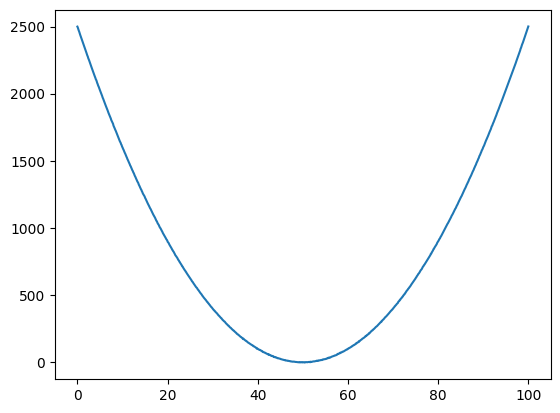

In [3]:
# First - Define simple quadratic curve to fit
x = np.linspace(0.0, 100.0, 1000)
y = (x-50)**2 + np.random.normal(size=(1000,))
plt.plot(x,y)

In [4]:
# WIP
# Let's see what happens if we pre-compute the ideal weights and biases by splitting the curve into 128 discrete segments
#def calculate_ideal(x, y, units)
#  return (weights, biases)
#
#calculate_ideal(x, y, 128)

Epoch 1/10
32/32 [==============================] - 1s 2ms/step - loss: 1226518.5000 - mse: 1226518.5000
Epoch 2/10
32/32 [==============================] - 0s 2ms/step - loss: 1190398.5000 - mse: 1190398.5000
Epoch 3/10
32/32 [==============================] - 0s 2ms/step - loss: 1145488.8750 - mse: 1145488.8750
Epoch 4/10
32/32 [==============================] - 0s 2ms/step - loss: 1092412.8750 - mse: 1092412.8750
Epoch 5/10
32/32 [==============================] - 0s 2ms/step - loss: 1031832.3750 - mse: 1031832.3750
Epoch 6/10
32/32 [==============================] - 0s 2ms/step - loss: 967492.0625 - mse: 967492.0625
Epoch 7/10
32/32 [==============================] - 0s 2ms/step - loss: 906711.8750 - mse: 906711.8750
Epoch 8/10
32/32 [==============================] - 0s 2ms/step - loss: 850778.1875 - mse: 850778.1875
Epoch 9/10
32/32 [==============================] - 0s 2ms/step - loss: 807613.3125 - mse: 807613.3125
Epoch 10/10
32/32 [==============================] - 0s 2ms/ste

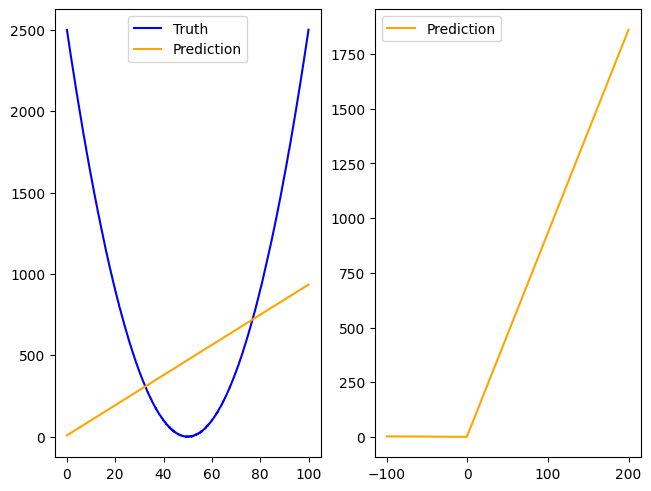

In [6]:
# This is the model that we're going to use in all cases.
# According to the "curve interpretation" of a ReLu activation layer, it can fit the curve piecewise, with 128 segments.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Firsty, try a pretty standard default setup (learning_rate defaults to 0.001)
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
model.fit(x, y, epochs=10)
plot_fit(model, x)

That sucks.
After some experimentations I found that I could get resonable results with a high learning rate and 100 epochs. Let's try that again...

Epoch    10: loss: 217475.5625  mse: 217475.5625  
Epoch    20: loss: 77441.1172  mse: 77441.1172  
Epoch    30: loss: 32539.0801  mse: 32539.0801  
Epoch    40: loss: 9032.5518  mse: 9032.5518  
Epoch    50: loss: 9304.5283  mse: 9304.5283  
Epoch    60: loss: 6050.8491  mse: 6050.8491  
Epoch    70: loss: 3642.9265  mse: 3642.9265  
Epoch    80: loss: 3496.6836  mse: 3496.6836  
Epoch    90: loss: 3879.6711  mse: 3879.6711  
Epoch   100: loss: 5472.2231  mse: 5472.2231  
32/32 [==============================] - 0s 4ms/step


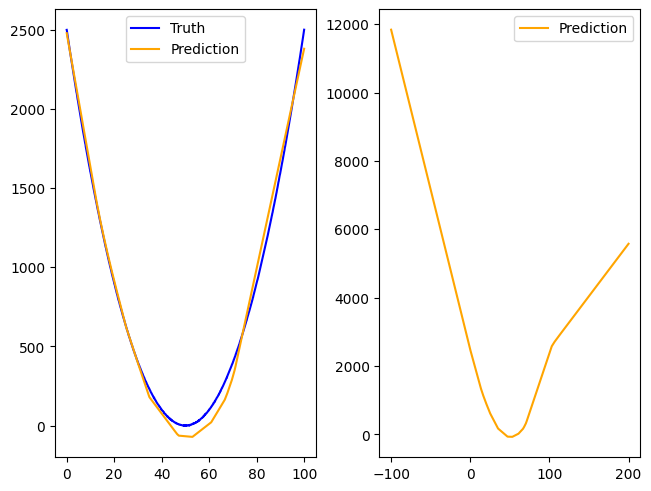

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mse', metrics=['mse'])
model.fit(x, y, epochs=100, verbose=0, callbacks = [LessVerboseEpochLogger(10)])
plot_fit(model, x)

In [ ]:
# WIP
# Let's see what happens if we pre-compute the ideal weights and biases by splitting the curve into 128 discrete segments
#def calculate_ideal(x, y, units)
#  return (weights, biases)
#
#calculate_ideal(x, y, 128)

Now let's try on a harder curve.

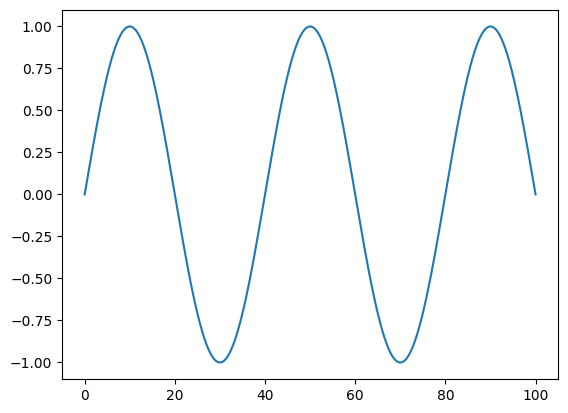

In [8]:
# Define sinusoidal curve to fit
x = np.linspace(0.0, 100.0, 1000)
y = np.sin(x/100.0 * np.pi * 5)
plt.plot(x,y)

With some experimentations, I found that I needed an intermediate learning rate and lots of epochs. And that was only enough to get it to begin to fit the curve. Here I'll show in a couple of training steps.

Epoch    10: loss: 0.5929  mse: 0.5929  
Epoch    20: loss: 0.6038  mse: 0.6038  
Epoch    30: loss: 0.6340  mse: 0.6340  
Epoch    40: loss: 0.4870  mse: 0.4870  
Epoch    50: loss: 0.4639  mse: 0.4639  
Epoch    60: loss: 0.4162  mse: 0.4162  
Epoch    70: loss: 0.4257  mse: 0.4257  
Epoch    80: loss: 0.3888  mse: 0.3888  
Epoch    90: loss: 0.3831  mse: 0.3831  
Epoch   100: loss: 0.3801  mse: 0.3801  
32/32 [==============================] - 0s 1ms/step


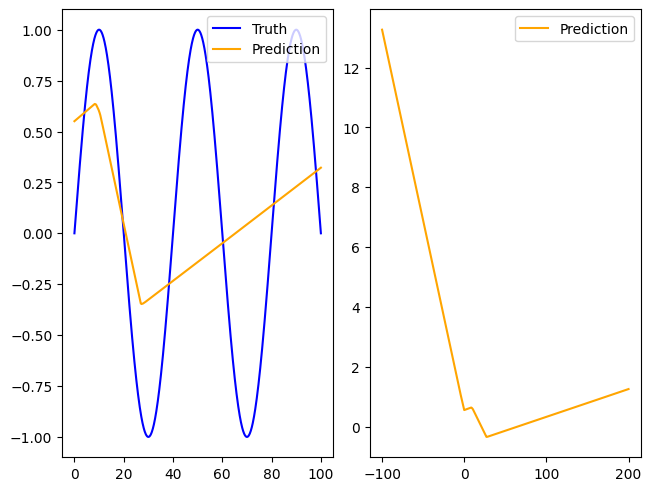

In [11]:
# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
model.fit(x, y, epochs=100, verbose=0, callbacks = [LessVerboseEpochLogger(10)])
plot_fit(model, x)

Epoch   100: loss: 0.3384  mse: 0.3384  
Epoch   200: loss: 0.2742  mse: 0.2742  
Epoch   300: loss: 0.2739  mse: 0.2739  
Epoch   400: loss: 0.2756  mse: 0.2756  
Epoch   500: loss: 0.2743  mse: 0.2743  
Epoch   600: loss: 0.2789  mse: 0.2789  
Epoch   700: loss: 0.2758  mse: 0.2758  
Epoch   800: loss: 0.2737  mse: 0.2737  
Epoch   900: loss: 0.2737  mse: 0.2737  
32/32 [==============================] - 0s 2ms/step


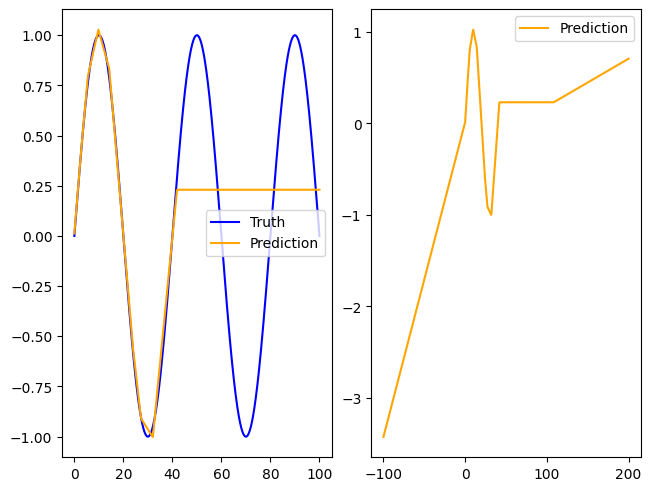

In [12]:
# Let's train for another 900 epochs so that we've done 1,000 epochs in total
history = model.fit(x, y, epochs=900, verbose=0, callbacks = [LessVerboseEpochLogger(100)])
plot_fit(model, x)

history objects: dict_keys(['loss', 'mse'])


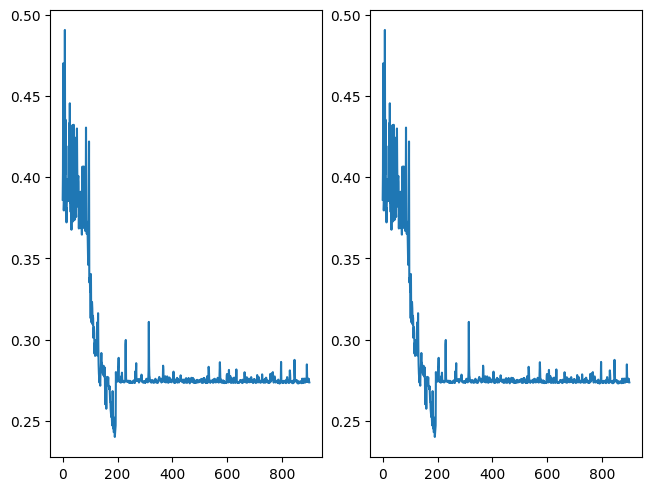

In [16]:
# Plotting history
print(f"history objects: {history.history.keys()}")
plt.figure(layout='constrained')
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.subplot(1,2,2)
plt.plot(history.history['mse'])

It appears the optimization algorithm has encountered a local minima. As a guess, it's probably something to do with the fact that it's trying to optimise all weights and biases at the same time. Ironically, it may do better with more noise in the input data set, in order to take better advantage of the _stochastic_ part of the SGD. Better yet, it would probably do better if each epoch trained on a similar but different data set - such as via "sampling with replacement".

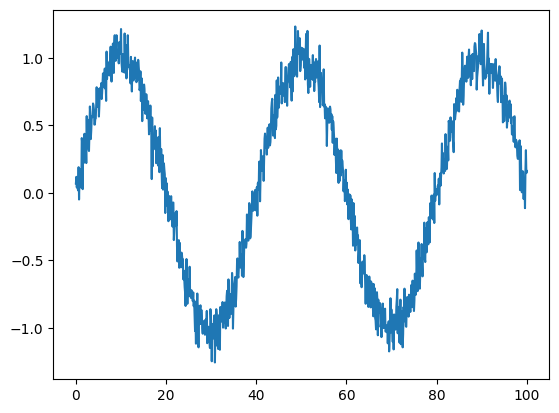

In [18]:
# Let's quickly try with noise added
x = np.linspace(0.0, 100.0, 1000)
y = np.sin(x/100.0 * np.pi * 5) + np.random.normal(size=(1000,))*0.1
plt.plot(x,y)

Epoch   100: loss: 0.3998  mse: 0.3998  
Epoch   200: loss: 0.3503  mse: 0.3503  
Epoch   300: loss: 0.3498  mse: 0.3498  
Epoch   400: loss: 0.3488  mse: 0.3488  
Epoch   500: loss: 0.3515  mse: 0.3515  
Epoch   600: loss: 0.3528  mse: 0.3528  
Epoch   700: loss: 0.3621  mse: 0.3621  
Epoch   800: loss: 0.3507  mse: 0.3507  
Epoch   900: loss: 0.3494  mse: 0.3494  
Epoch  1000: loss: 0.3529  mse: 0.3529  
32/32 [==============================] - 0s 1ms/step


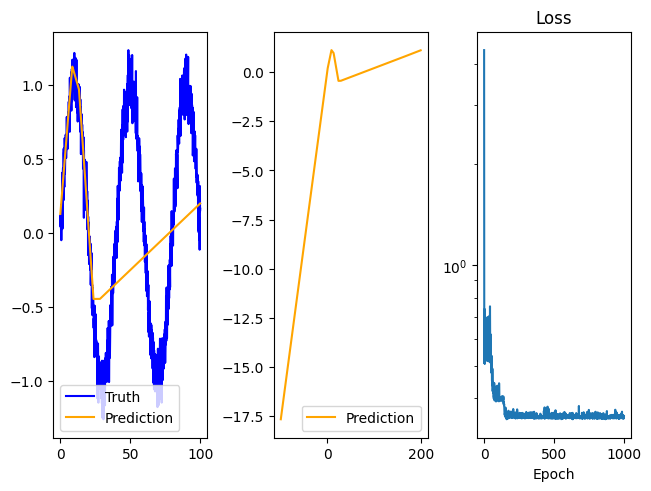

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(x, y, epochs=1000, verbose=0, callbacks = [LessVerboseEpochLogger(100)])
plot_fit(model, x, history)

Epoch   100: loss: 0.4962  mse: 0.4962  
Epoch   200: loss: 0.4958  mse: 0.4958  
Epoch   300: loss: 0.4958  mse: 0.4958  
Epoch   400: loss: 0.4957  mse: 0.4957  
Epoch   500: loss: 0.4957  mse: 0.4957  
32/32 [==============================] - 0s 1ms/step


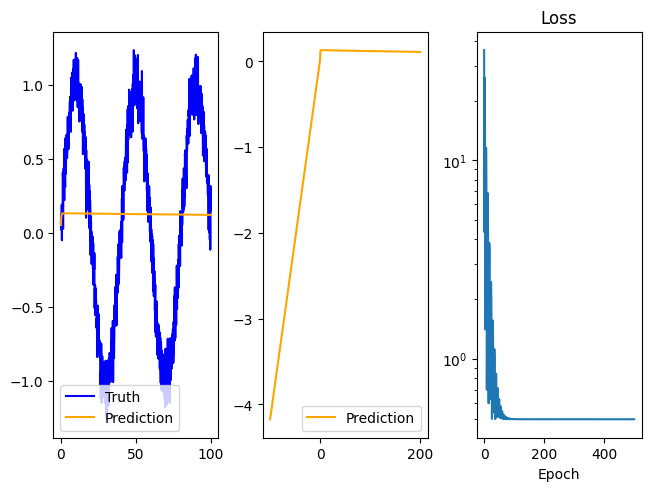

In [33]:
# Let's try something simpler.
# It turns out that TensorFlow by default batches on size 32. Meaning that it applies a gradient update every 32 samples.
# But because of the way that I've structured the dataset, that means that it trains on narrow 32/1000 segments of the x-range.
# Let's try increasing the batch size to the full dataset.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(x, y, epochs=500, batch_size=len(x), verbose=0, callbacks = [LessVerboseEpochLogger(100)])
plot_fit(model, x, history)

Epoch   100: loss: 0.4470  mse: 0.4470  
Epoch   200: loss: 0.4011  mse: 0.4011  
Epoch   300: loss: 0.3224  mse: 0.3224  
Epoch   400: loss: 0.3374  mse: 0.3374  
Epoch   500: loss: 0.3232  mse: 0.3232  
32/32 [==============================] - 0s 1ms/step


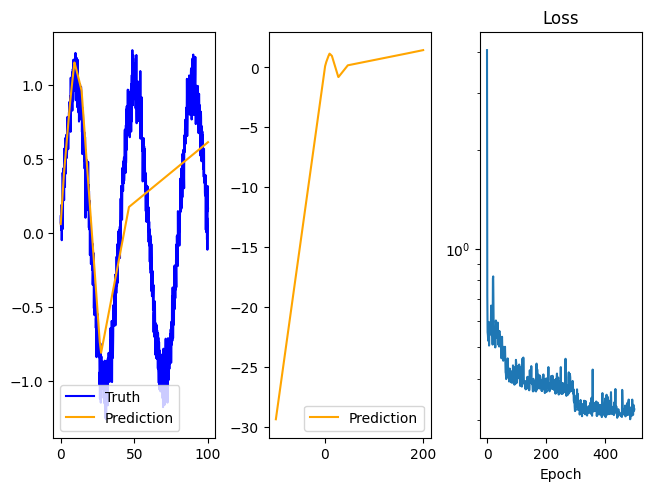

In [34]:
# Alternatively, let's leave the batch-size as is, but shuffle the dataset.
shuffle_index = tf.random.uniform(shape=(len(x),), maxval=len(x), dtype=tf.int32)
x_shuffle = x[shuffle_index]
y_shuffle = y[shuffle_index]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(x_shuffle, y_shuffle, epochs=500, verbose=0, callbacks = [LessVerboseEpochLogger(100)])
plot_fit(model, x, history)

Epoch   100: loss: 0.4114  mse: 0.4114  
Epoch   200: loss: 0.3361  mse: 0.3361  
Epoch   300: loss: 0.2724  mse: 0.2724  
Epoch   400: loss: 0.2726  mse: 0.2726  
Epoch   500: loss: 0.2753  mse: 0.2753  
32/32 [==============================] - 0s 2ms/step


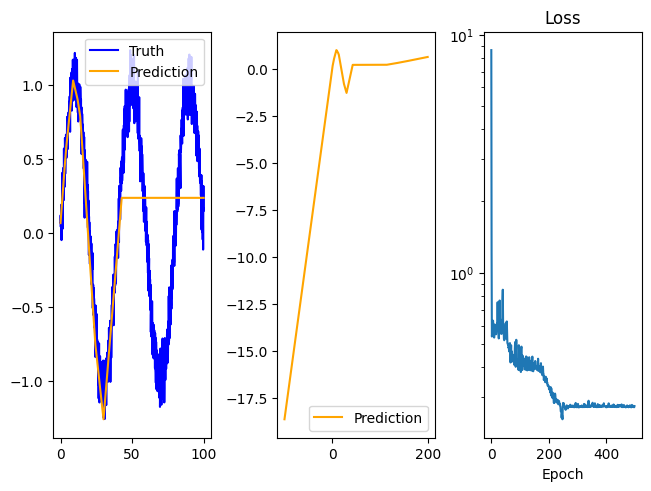

In [43]:
# Now lets try using 'sampling with replacement', generating a slightly different dataset each epoch
def sample_with_replacement(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    sampled_indices = tf.random.uniform(shape=(len(X),), maxval=len(X), dtype=tf.int32)
    sampled_dataset = tf.data.Dataset.from_tensor_slices((
        tf.gather(X, sampled_indices),
        tf.gather(y, sampled_indices)
    ))
    sampled_dataset = sampled_dataset.shuffle(buffer_size=len(X)).batch(32)
    return sampled_dataset

sampled_dataset = sample_with_replacement(x, y)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(sampled_dataset, epochs=500, verbose=0, callbacks = [LessVerboseEpochLogger(100)])
plot_fit(model, x, history)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(x, y, epochs=500, batch_size=len(x), verbose=0, callbacks = [LessVerboseEpochLogger(100)])
plot_fit(model, x, history)

AttributeError: '_ShuffleDataset' object has no attribute 'size'

After some learnings, I got a slightly different variant working in another notebook running disturbingly quickly per epoch. Why?


Epoch   500: loss: 0.4645  mse: 0.4645  
Epoch  1000: loss: 0.3566  mse: 0.3566  
Epoch  1500: loss: 0.3434  mse: 0.3434  
Epoch  2000: loss: 0.3425  mse: 0.3425  
Epoch  2500: loss: 0.3383  mse: 0.3383  
Epoch  3000: loss: 0.3184  mse: 0.3184  
Epoch  3500: loss: 0.4213  mse: 0.4213  
Epoch  4000: loss: 0.2855  mse: 0.2855  
Epoch  4500: loss: 0.4160  mse: 0.4160  
Epoch  5000: loss: 0.2758  mse: 0.2758  
Epoch  5500: loss: 0.2746  mse: 0.2746  
Epoch  6000: loss: 0.2741  mse: 0.2741  
Epoch  6500: loss: 0.2736  mse: 0.2736  
Epoch  7000: loss: 0.2737  mse: 0.2737  
Epoch  7500: loss: 0.2736  mse: 0.2736  
Epoch  8000: loss: 0.2736  mse: 0.2736  
Epoch  8500: loss: 0.2736  mse: 0.2736  
Epoch  9000: loss: 0.1566  mse: 0.1566  
Epoch  9500: loss: 0.0881  mse: 0.0881  
Epoch 10000: loss: 0.0706  mse: 0.0706  
32/32 [==============================] - 0s 1ms/step


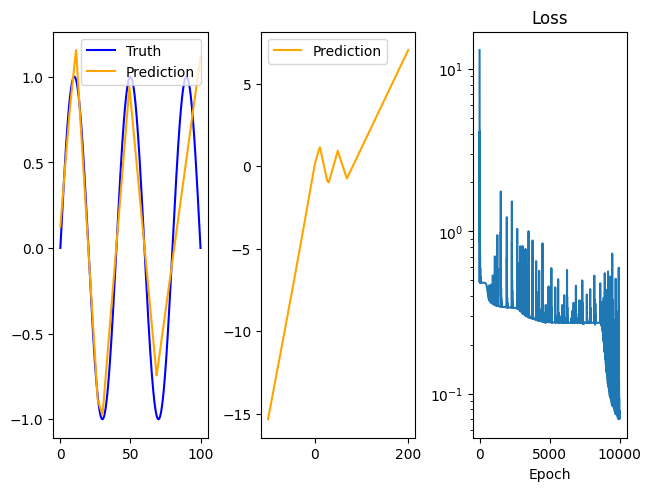

In [9]:
# Fast version - 500 epochs in about 2.5s
# - Turns out to be the batch_size.
idx = np.random.permutation(len(x))
x_train = x[idx]
y_train = y[idx]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])
history = model.fit(x_train, y_train, epochs=10000, batch_size=len(x_train), verbose=0, callbacks = [LessVerboseEpochLogger(500)])
plot_fit(model, x, history)

In [13]:
# Let's compare the learning charts with different batch sizes
print("Run 1")
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_32 = model.fit(x, y, epochs=1000, batch_size=32, verbose=0, callbacks = [LessVerboseEpochLogger(100)])

print("Run 2")
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_full = model.fit(x, y, epochs=1000, batch_size=len(x), verbose=0, callbacks = [LessVerboseEpochLogger(100)])

Run 1
Epoch   100: loss: 0.3748  mse: 0.3748  
Epoch   200: loss: 0.3673  mse: 0.3673  
Epoch   300: loss: 0.3061  mse: 0.3061  
Epoch   400: loss: 0.2921  mse: 0.2921  
Epoch   500: loss: 0.2946  mse: 0.2946  
Epoch   600: loss: 0.3012  mse: 0.3012  
Epoch   700: loss: 0.3038  mse: 0.3038  
Epoch   800: loss: 0.3135  mse: 0.3135  
Epoch   900: loss: 0.2914  mse: 0.2914  
Epoch  1000: loss: 0.3085  mse: 0.3085  
Run 2
Epoch   100: loss: 0.4883  mse: 0.4883  
Epoch   200: loss: 0.4836  mse: 0.4836  
Epoch   300: loss: 0.4833  mse: 0.4833  
Epoch   400: loss: 0.4833  mse: 0.4833  
Epoch   500: loss: 0.4833  mse: 0.4833  
Epoch   600: loss: 0.4833  mse: 0.4833  
Epoch   700: loss: 0.4833  mse: 0.4833  
Epoch   800: loss: 0.4833  mse: 0.4833  
Epoch   900: loss: 0.4833  mse: 0.4833  
Epoch  1000: loss: 0.4833  mse: 0.4833  


In [15]:
print("Run 3")
idx = np.random.permutation(len(x))
x_shuffled = x[idx]
y_shuffled = y[idx]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_32_shuffled = model.fit(x_shuffled, y_shuffled, epochs=1000, batch_size=32, verbose=0, callbacks = [LessVerboseEpochLogger(100)])

Run 3
Epoch   100: loss: 0.4627  mse: 0.4627  
Epoch   200: loss: 0.3898  mse: 0.3898  
Epoch   300: loss: 0.3251  mse: 0.3251  
Epoch   400: loss: 0.2959  mse: 0.2959  
Epoch   500: loss: 0.3271  mse: 0.3271  
Epoch   600: loss: 0.3006  mse: 0.3006  
Epoch   700: loss: 0.3362  mse: 0.3362  
Epoch   800: loss: 0.2900  mse: 0.2900  
Epoch   900: loss: 0.2971  mse: 0.2971  
Epoch  1000: loss: 0.3046  mse: 0.3046  


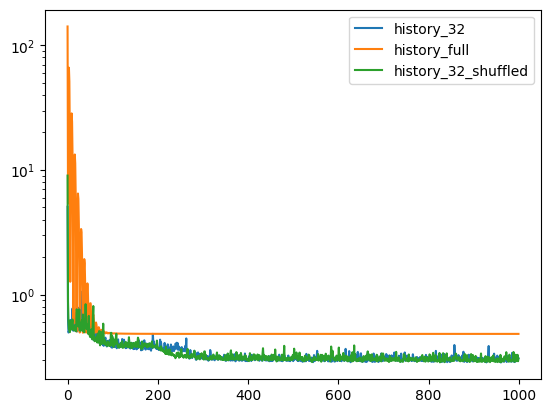

In [19]:
plt.plot(history_32.history['mse'], label='history_32')
plt.plot(history_full.history['mse'], label='history_full')
plt.plot(history_32_shuffled.history['mse'], label='history_32_shuffled')
plt.yscale('log')
plt.legend()

It's quite amazing that the full batch size converges slower and stops earlier. And yet it's so much master that it's easier to run for more epochs.
Let's do the painful thing of running all three approaches to 10000 epochs.

In [21]:
# Let's compare the learning charts with different batch sizes
print("Run 1")
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_32 = model.fit(x, y, epochs=10000, batch_size=32, verbose=0, callbacks = [LessVerboseEpochLogger(500)])
model_32 = model

print("Run 2")
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_full = model.fit(x, y, epochs=10000, batch_size=len(x), verbose=0, callbacks = [LessVerboseEpochLogger(500)])
model_full = model

print("Run 3")
idx = np.random.permutation(len(x))
x_shuffled = x[idx]
y_shuffled = y[idx]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_32_shuffled = model.fit(x_shuffled, y_shuffled, epochs=10000, batch_size=32, verbose=0, callbacks = [LessVerboseEpochLogger(500)])
model_32_shuffled = model

Run 1
Epoch   500: loss: 0.2739  mse: 0.2739  
Epoch  1000: loss: 0.2862  mse: 0.2862  
Epoch  1500: loss: 0.2741  mse: 0.2741  
Epoch  2000: loss: 0.2737  mse: 0.2737  
Epoch  2500: loss: 0.2740  mse: 0.2740  
Epoch  3000: loss: 0.2741  mse: 0.2741  
Epoch  3500: loss: 0.2740  mse: 0.2740  
Epoch  4000: loss: 0.2767  mse: 0.2767  
Epoch  4500: loss: 0.2741  mse: 0.2741  
Epoch  5000: loss: 0.2751  mse: 0.2751  
Epoch  5500: loss: 0.2738  mse: 0.2738  
Epoch  6000: loss: 0.2744  mse: 0.2744  
Epoch  6500: loss: 0.2743  mse: 0.2743  
Epoch  7000: loss: 0.2733  mse: 0.2733  
Epoch  7500: loss: 0.2738  mse: 0.2738  
Epoch  8000: loss: 0.2740  mse: 0.2740  
Epoch  8500: loss: 0.2738  mse: 0.2738  
Epoch  9000: loss: 0.2737  mse: 0.2737  
Epoch  9500: loss: 0.2742  mse: 0.2742  
Epoch 10000: loss: 0.2735  mse: 0.2735  
Run 2
Epoch   500: loss: 0.4833  mse: 0.4833  
Epoch  1000: loss: 0.4830  mse: 0.4830  
Epoch  1500: loss: 0.4545  mse: 0.4545  
Epoch  2000: loss: 0.3541  mse: 0.3541  
Epoc

32/32 [==============================] - 0s 1ms/step


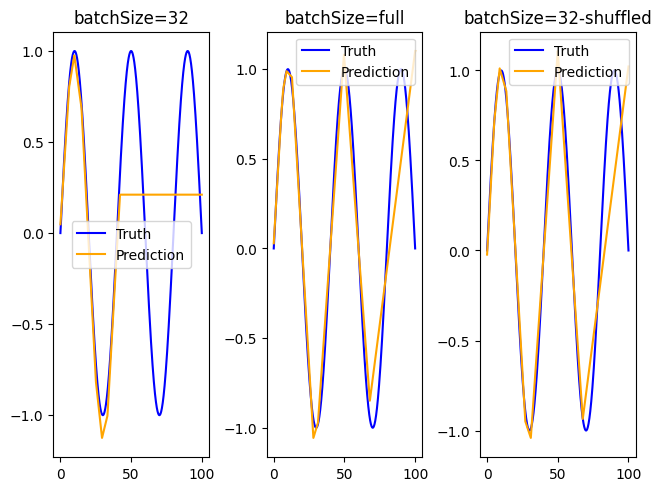

In [25]:
# Plotting the resultant fits

# Plot model results
plt.figure(layout='constrained')

plt.subplot(1,3,1)
plt.title('batchSize=32')
y_predict = model_32.predict(x)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange', label="Prediction")
plt.legend()

plt.subplot(1,3,2)
plt.title('batchSize=full')
y_predict = model_full.predict(x)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange', label="Prediction")
plt.legend()

plt.subplot(1,3,3)
plt.title('batchSize=32-shuffled')
y_predict = model_32_shuffled.predict(x)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange', label="Prediction")
plt.legend()


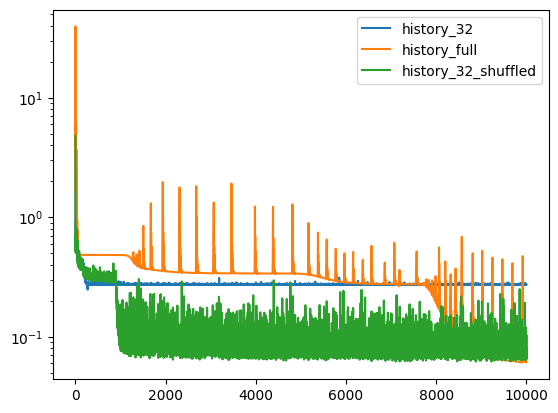

In [22]:
# Learning curves
plt.plot(history_32.history['mse'], label='history_32')
plt.plot(history_full.history['mse'], label='history_full')
plt.plot(history_32_shuffled.history['mse'], label='history_32_shuffled')
plt.yscale('log')
plt.legend()

Now we can see that a naive batchSize 32 is clearly not good enough. This approach causes the network to learn against little segments of the total curve, overwriting itself at each step.

I'm surprised that using the full dataset is slower than 32-shuffled (per-epoch). Perhaps it's to do with the risk of local minima. Using the full dataset each epoch means that it has no stochastic noise to help it escape the minima. In contrast, using batchSize 32 on the shuffled data gives a representative sub-sample of the entire sinosoid each epoch.

I expect that an optimum is somewhere in between, such as using batchSize of 100, which provides enough points to accurately represent the curve, but also provides enough variation between batches. Let's pick 100 and compare on 1000 epochs.

After that, we'll experiment with different learning rates.

In [26]:
# Let's compare the learning charts with different batch sizes
print("Run 1")
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_32 = model.fit(x, y, epochs=1000, batch_size=32, verbose=0, callbacks = [LessVerboseEpochLogger(100)])
model_32 = model

print("Run 2")
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_full = model.fit(x, y, epochs=1000, batch_size=len(x), verbose=0, callbacks = [LessVerboseEpochLogger(100)])
model_full = model

print("Run 3")
idx = np.random.permutation(len(x))
x_shuffled = x[idx]
y_shuffled = y[idx]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_32_shuffled = model.fit(x_shuffled, y_shuffled, epochs=1000, batch_size=32, verbose=0, callbacks = [LessVerboseEpochLogger(100)])
model_32_shuffled = model

print("Run 4")
idx = np.random.permutation(len(x))
x_shuffled = x[idx]
y_shuffled = y[idx]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history_100_shuffled = model.fit(x_shuffled, y_shuffled, epochs=1000, batch_size=100, verbose=0, callbacks = [LessVerboseEpochLogger(100)])
model_100_shuffled = model

Run 1
Epoch   100: loss: 0.4215  mse: 0.4215  
Epoch   200: loss: 0.3363  mse: 0.3363  
Epoch   300: loss: 0.3261  mse: 0.3261  
Epoch   400: loss: 0.3122  mse: 0.3122  
Epoch   500: loss: 0.3026  mse: 0.3026  
Epoch   600: loss: 0.3100  mse: 0.3100  
Epoch   700: loss: 0.2956  mse: 0.2956  
Epoch   800: loss: 0.3039  mse: 0.3039  
Epoch   900: loss: 0.2903  mse: 0.2903  
Epoch  1000: loss: 0.2908  mse: 0.2908  
Run 2
Epoch   100: loss: 0.4833  mse: 0.4833  
Epoch   200: loss: 0.4833  mse: 0.4833  
Epoch   300: loss: 0.4833  mse: 0.4833  
Epoch   400: loss: 0.4832  mse: 0.4832  
Epoch   500: loss: 0.4830  mse: 0.4830  
Epoch   600: loss: 0.4825  mse: 0.4825  
Epoch   700: loss: 0.4811  mse: 0.4811  
Epoch   800: loss: 0.4766  mse: 0.4766  
Epoch   900: loss: 0.4633  mse: 0.4633  
Epoch  1000: loss: 0.4353  mse: 0.4353  
Run 3
Epoch   100: loss: 0.3966  mse: 0.3966  
Epoch   200: loss: 0.3962  mse: 0.3962  
Epoch   300: loss: 0.3173  mse: 0.3173  
Epoch   400: loss: 0.3225  mse: 0.3225 

32/32 [==============================] - 0s 4ms/step


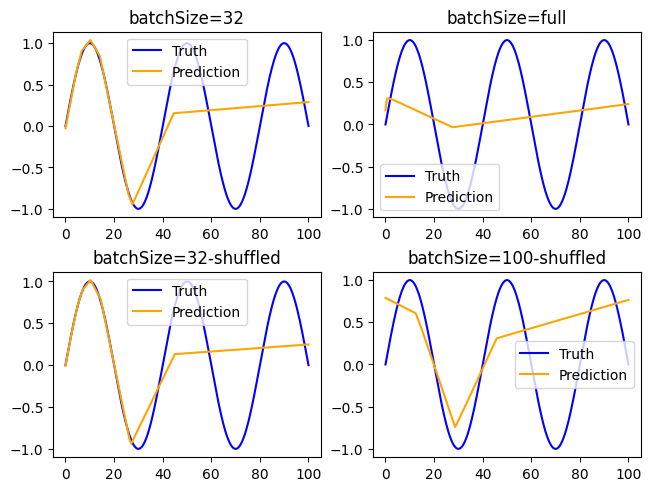

In [28]:
# Plotting the resultant fits

# Plot model results
plt.figure(layout='constrained')

plt.subplot(2,2,1)
plt.title('batchSize=32')
y_predict = model_32.predict(x)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange', label="Prediction")
plt.legend()

plt.subplot(2,2,2)
plt.title('batchSize=full')
y_predict = model_full.predict(x)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange', label="Prediction")
plt.legend()

plt.subplot(2,2,3)
plt.title('batchSize=32-shuffled')
y_predict = model_32_shuffled.predict(x)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange', label="Prediction")
plt.legend()

plt.subplot(2,2,4)
plt.title('batchSize=100-shuffled')
y_predict = model_100_shuffled.predict(x)
plt.plot(x,y, color='blue', label="Truth")
plt.plot(x,y_predict, color='orange', label="Prediction")
plt.legend()

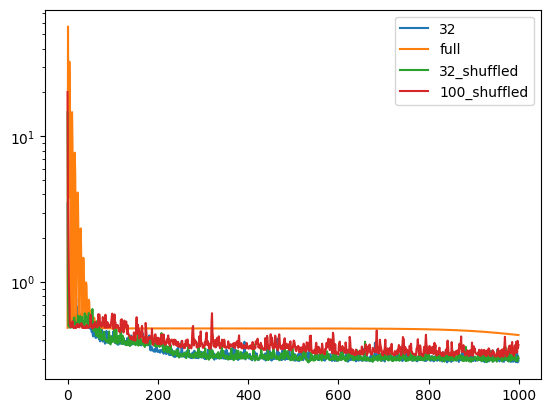

In [29]:
# Learning curves
plt.plot(history_32.history['mse'], label='32')
plt.plot(history_full.history['mse'], label='full')
plt.plot(history_32_shuffled.history['mse'], label='32_shuffled')
plt.plot(history_100_shuffled.history['mse'], label='100_shuffled')
plt.yscale('log')
plt.legend()

So, batch-size 100 is still going to be slower than using the full dataset each epoch. The reason is that we're not taking full advantage of the GPU's capacity. Larger batch sizes push more data in one go, reducing the total round-trip overheads.

An alternative is to simulate some more stochastic noise and to make the dataset bigger:
* Sample the curve at a much higher resolution, but with noise added.
* Shuffle the dataset.
* Then use batchSize 1000

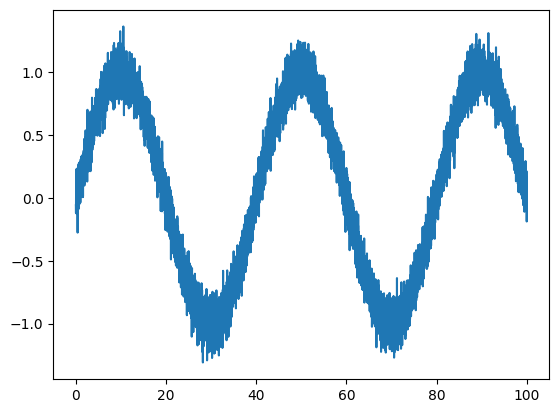

In [31]:
x = np.linspace(0.0, 100.0, 10000)
y = np.sin(x/100.0 * np.pi * 5) + np.random.normal(size=(10000,))*0.1
plt.plot(x,y)

In [32]:
idx = np.random.permutation(len(x))
x_shuffled = x[idx]
y_shuffled = y[idx]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(x_shuffled, y_shuffled, epochs=1000, batch_size=100, verbose=0, callbacks = [LessVerboseEpochLogger(100)])

Epoch   100: loss: 0.3240  mse: 0.3240  
Epoch   200: loss: 0.1211  mse: 0.1211  
Epoch   300: loss: 0.1009  mse: 0.1009  
Epoch   400: loss: 0.1354  mse: 0.1354  
Epoch   500: loss: 0.0874  mse: 0.0874  
Epoch   600: loss: 0.0831  mse: 0.0831  
Epoch   700: loss: 0.0788  mse: 0.0788  
Epoch   800: loss: 0.0930  mse: 0.0930  
Epoch   900: loss: 0.0911  mse: 0.0911  
Epoch  1000: loss: 0.0917  mse: 0.0917  


32/32 [==============================] - 0s 2ms/step


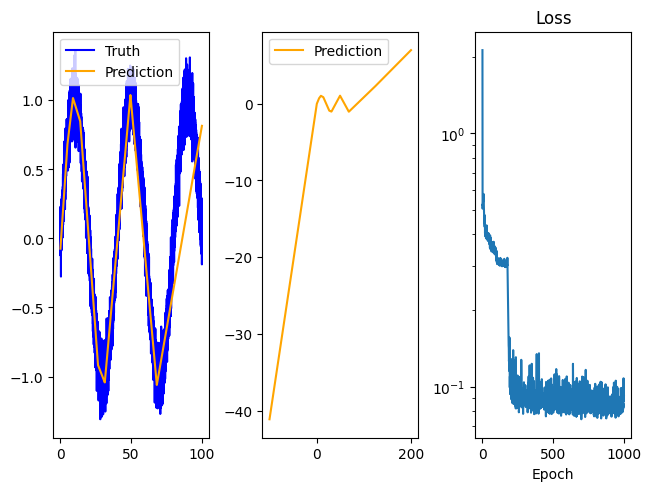

In [33]:
plot_fit(model, x, history)

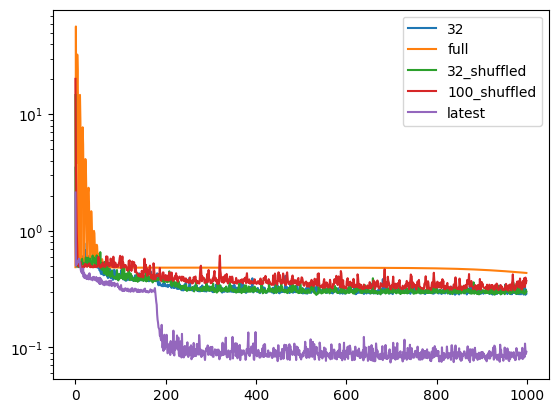

In [34]:
# Learning curves
plt.plot(history_32.history['mse'], label='32')
plt.plot(history_full.history['mse'], label='full')
plt.plot(history_32_shuffled.history['mse'], label='32_shuffled')
plt.plot(history_100_shuffled.history['mse'], label='100_shuffled')
plt.plot(history.history['mse'], label='latest')
plt.yscale('log')
plt.legend()